In [27]:
from typing import Any
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import numpy as np
import pandas as pd
from torch import Tensor
from torch.optim import Adam
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer, callbacks
import plotly.express as px

from non_parametric_ml.decorators import numpy_to_torch
from non_parametric_ml.pytorch_tools.losses import SmoothPinballLoss, PinballLoss

import plotly.io as pio

# Set the default template for plotly
pio.templates.default = 'plotly_white'

@numpy_to_torch
def create_data(multimodal: bool):
    X = np.random.uniform(0.3, 10, 1000)
    y = np.log(X) + np.random.exponential(0.1 + X / 20.0)

    if multimodal:
        X = np.concatenate([X, np.random.uniform(5, 10, 500)])
        y = np.concatenate([y, np.random.normal(6.0, 0.3, 500)])
    
    # X = torch.from_numpy(X[..., None]).float()
    # y = torch.from_numpy(y[..., None]).float()

    return X, y


In [28]:
multimodal: bool = False
X, y = create_data(multimodal)

In [29]:
class BinarizedQuantileLoss(nn.Module):
    """
    Calculates the quantile loss function.

    Attributes
    ----------
    self.pred : torch.tensor
        Predictions.
    self.target : torch.tensor
        Target to predict.
    self.quantiles : torch.tensor
    """
    def __init__(self, quantiles):
        super(BinarizedQuantileLoss, self).__init__()
        self.register_buffer('quantiles', torch.tensor(quantiles, dtype=torch.float))
        self.qloss_low = PinballLoss(quantiles[0])
        self.qloss_high = PinballLoss(quantiles[-1])

    @staticmethod
    def find_bin_indices(y_true, q_low, q_high, n_bins):
        range = q_high - q_low
        bin_size = range / n_bins
        # Calculate bin indices for all y_true values in a vectorized manner
        bin_indices = ((y_true - q_low) / bin_size).floor().long()
        # Clamp bin indices to ensure they fall within the valid range of bins, also vectorized
        bin_indices = torch.clamp(bin_indices, 0, n_bins - 1)
        return bin_indices
        
    def forward(self, q_hat, y_true):
        q_low = q_hat[:, 0:1]
        q_high = q_hat[:, -1:]
        q_interm = q_hat[:, 1:-1] # NOTE: perhaps the last quantile column should not be included as well for this to work

        bin_labels = self.find_bin_indices(y_true, q_low, q_high, q_interm.size(1)).squeeze()
        ce_loss = F.cross_entropy(q_interm, bin_labels)
        q_loss = self.qloss_low(q_low, y_true) + self.qloss_high(q_high, y_true)

        return ce_loss + q_loss

In [30]:
class LinearQuantReg(pl.LightningModule):
    def __init__(self, din, quantiles, loss_fn=None, name=None):
        super().__init__()
        self.din = din
        self.quantiles = quantiles
        self.loss_fn = loss_fn if loss_fn is not None else PinballLoss(quantiles)
        self.fc = nn.Linear(din, len(quantiles))
        self.model_name = name if name is not None else self.__class__.__name__

    def forward(self, X):
        return self.fc(X)
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-4)

class QuantReg(pl.LightningModule):
    def __init__(self, din, quantiles, loss_fn=None, name=None):
        super().__init__()
        self.din = din
        self.quantiles = quantiles
        self.loss_fn = loss_fn if loss_fn is not None else PinballLoss(quantiles)
        # self.fc = nn.Sequential(
        #     nn.Linear(din, 64),
        #     nn.ReLU(),
        #     nn.Linear(64, len(quantiles))
        # )

        self.fc = nn.Sequential(
            nn.Linear(din, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, len(quantiles))
        )
        self.model_name = name if name is not None else self.__class__.__name__

    def forward(self, X):
        return self.fc(X)
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-4)

In [31]:
class NonCrossLinearQuantReg(pl.LightningModule):
    def __init__(self, din, quantiles, loss_fn = None, name=None):
        super().__init__()
        assert len(quantiles) > 2, "There should be more than 2 quantiles"

        self.din = din
        self.loss_fn = loss_fn if loss_fn is not None else PinballLoss(quantiles)
        self.scores_fc = nn.Linear(din, len(quantiles) - 1)
        self.width_fc = nn.Linear(din, 1)
        self.min_fc = nn.Linear(din, 1)

        self.model_name = name if name is not None else self.__class__.__name__

    def forward(self, X):
        min: Tensor = self.min_fc(X)
        width: Tensor = F.softplus(self.width_fc(X))
        scores: Tensor = F.softmax(self.scores_fc(X), dim=1)
        scores_with_zeros: Tensor = torch.cat((torch.zeros_like(min), scores), dim=-1)

        # Compute proportions by cumulatively summing the scores_tensor
        proportions: Tensor = torch.cumsum(scores_with_zeros, dim=-1)
        
        # Calculate final quantiles
        values: Tensor = min + width * proportions
        return values
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)
        loss = self.loss_fn(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-4)
    
class NonCrossQuantReg(pl.LightningModule):
    def __init__(self, din, quantiles, loss_fn = None, name=None):
        super().__init__()
        assert len(quantiles) > 2, "There should be more than 2 quantiles"
        self.model_name = name if name is not None else self.__class__.__name__

        self.din = din
        self.loss_fn = loss_fn if loss_fn is not None else PinballLoss(quantiles)

        #self.scores_fc = nn.Linear(din, len(quantiles) - 1)

        # self.scores_fc = nn.Sequential(
        #     nn.Linear(din, 64),
        #     nn.ReLU(),
        #     nn.Linear(64, len(quantiles) - 1)
        # )

        self.scores_fc = nn.Sequential(
            nn.Linear(din, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, len(quantiles) - 1)
        )

        # self.width_fc = nn.Sequential(
        #     nn.Linear(din, 64),
        #     nn.ReLU(),
        #     nn.Linear(64, 1)
        # )

        self.width_fc = nn.Sequential(
            nn.Linear(din, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        # Introduce non-linear layers for min
        # self.min_fc = nn.Sequential(
        #     nn.Linear(din, 64),
        #     nn.ReLU(),
        #     nn.Linear(64, 1)
        # )

        self.min_fc = nn.Sequential(
            nn.Linear(din, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, X):
        min: Tensor = self.min_fc(X)
        width: Tensor = F.softplus(self.width_fc(X))
        scores: Tensor = F.softmax(self.scores_fc(X), dim=1)
        scores_with_zeros: Tensor = torch.cat((torch.zeros_like(min), scores), dim=-1)

        # Compute proportions by cumulatively summing the scores_tensor
        proportions: Tensor = torch.cumsum(scores_with_zeros, dim=-1)
        
        # Calculate final quantiles
        values: Tensor = min + width * proportions
        return values
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)
        loss = self.loss_fn(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-4)

In [32]:
# Define a factory function for creating models with automatic naming
def create_model(din, quantiles, loss_fn, model_class=NonCrossLinearQuantReg):
    # Generate a name based on the model class and loss function
    model_name = f"{model_class.__name__}_{loss_fn.__class__.__name__}"
    
    # Initialize the model with the generated name
    model = model_class(din=din, quantiles=quantiles, loss_fn=loss_fn, name=model_name)
    return model

def train_and_evaluate(model, dataloader, max_epochs=3001, patience = 50):
    logger = TensorBoardLogger("tensorboard", name=model.model_name)
    early_stop_callback = callbacks.EarlyStopping(
        monitor='train_loss',
        patience=patience,
        verbose=True,
        mode='min'
    )
    trainer = Trainer(
        max_epochs=max_epochs,
        logger=logger,
        callbacks=[early_stop_callback]
    )
    trainer.fit(model, dataloader)

def predict(model, X, no_grad = False):
    model.eval()  # Set the model to evaluation mode
    
    if no_grad:
        with torch.no_grad():  # Disable gradient calculation
            y_hat = model(X).detach().numpy()
    else:
        y_hat = model(X).detach().numpy()
        
    return y_hat

In [33]:
# qs = [0.01, *np.linspace(0.1, 0.95, 8), 0.99]
qs = np.linspace(0.01, 0.99, 10)
batch_size = 64
din = 1  # Dimension of input
# qs = (0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95)
qnames = [f"q{q:.2f}" for q in qs]


dataloader  = DataLoader(TensorDataset(X, y), batch_size=batch_size, shuffle=True)

In [34]:
# Create a model selector dictionary
model_selector = {
    'linear_pinball': lambda: create_model(din=din, quantiles=qs, loss_fn=PinballLoss(qs), model_class=LinearQuantReg),
    'linear_smooth': lambda: create_model(din=din, quantiles=qs, loss_fn=SmoothPinballLoss(qs), model_class=LinearQuantReg),
    'linear_binarized': lambda: create_model(din=din, quantiles=qs, loss_fn=BinarizedQuantileLoss(qs), model_class=LinearQuantReg),

    'noncross_linear_pinball': lambda: create_model(din=din, quantiles=qs, loss_fn=PinballLoss(qs), model_class=NonCrossLinearQuantReg),
    'noncross_linear_smooth': lambda: create_model(din=din, quantiles=qs, loss_fn=SmoothPinballLoss(qs), model_class=NonCrossLinearQuantReg),
    'noncross_linear_binarized': lambda: create_model(din=din, quantiles=qs, loss_fn=BinarizedQuantileLoss(qs), model_class=NonCrossLinearQuantReg),

    'nonlinear_smooth': lambda: create_model(din=din, quantiles=qs, loss_fn=SmoothPinballLoss(qs), model_class=QuantReg),
    'nonlinear_pinball': lambda: create_model(din=din, quantiles=qs, loss_fn=PinballLoss(qs), model_class=QuantReg),
    'nonlinear_binarized': lambda: create_model(din=din, quantiles=qs, loss_fn=BinarizedQuantileLoss(qs), model_class=QuantReg),

    'noncross_nonlinear_smooth': lambda: create_model(din=din, quantiles=qs, loss_fn=SmoothPinballLoss(qs), model_class=NonCrossQuantReg),
    'noncross_nonlinear_pinball': lambda: create_model(din=din, quantiles=qs, loss_fn=PinballLoss(qs), model_class=NonCrossQuantReg),
    'noncross_nonlinear_binarized': lambda: create_model(din=din, quantiles=qs, loss_fn=BinarizedQuantileLoss(qs), model_class=NonCrossQuantReg),
}

In [35]:
model_name = 'noncross_nonlinear_binarized'
# Example usage to select a model:
selected_model = model_selector[model_name]()

train_and_evaluate(selected_model, dataloader, patience=50)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type                  | Params
----------------------------------------------------
0 | loss_fn   | BinarizedQuantileLoss | 0     
1 | scores_fc | Sequential            | 9.1 K 
2 | width_fc  | Sequential            | 8.6 K 
3 | min_fc    | Sequential            | 8.6 K 
----------------------------------------------------
26.3 K    Trainable params
0         Non-trainable params
26.3 K    Total params
0.105     Total estimated model params size (MB)
/Users/matejuhrin/repo/non-parametric-ml/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/Users/matejuhri

Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 71.47it/s, v_num=1]

Metric train_loss improved. New best score: 2.121


Epoch 6:  88%|████████▊ | 14/16 [00:00<00:00, 83.78it/s, v_num=1]

/Users/matejuhrin/repo/non-parametric-ml/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...



In [ ]:
y_hat = predict(selected_model, X)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

y_hat_df = (pd.DataFrame(y_hat, columns = qnames)
            .assign(
                X = X.numpy(),
                y = y.numpy()
            )
            .sort_values("X")
)

y_hat_df

# Assuming y_hat_df is your DataFrame and it contains columns 'X', 'q0.50', 'q0.95'
fig = px.line(y_hat_df, x='X', y=qnames, title="MQR qloss(low, high) + xentropy loss")
fig.add_trace(go.Scatter(x=y_hat_df['X'], y=y_hat_df['y'], mode='markers', name='True values'))
fig.show()

In [ ]:
def get_pdf(quantiles, q_values):
    densities = []
    for i in range(len(quantiles) - 1):
        area = quantiles[i + 1] - quantiles[i]
        b = q_values[i + 1] - q_values[i]
        a = area / b
        densities.append(a)
    return densities

def piecewise(xs):
    return [xs[i + j] for i in range(len(xs) - 1) for j in range(2)]

def doubled(xs):
    return [np.clip(xs[i], 0, 3) for i in range(len(xs)) for _ in range(2)]

In [ ]:
import matplotlib.pyplot as plt

xi = 7.0
selected_model.eval()
with torch.no_grad():
    q_vals = selected_model(torch.tensor([[xi]])).detach().squeeze().numpy()

q_vals

array([1.7879791, 3.604815 , 3.6601908, 3.6609426, 3.6609511, 3.6609526,
       3.6609547, 3.6609638, 3.6610367, 3.6621094], dtype=float32)

Text(0, 0.5, 'p(y)')

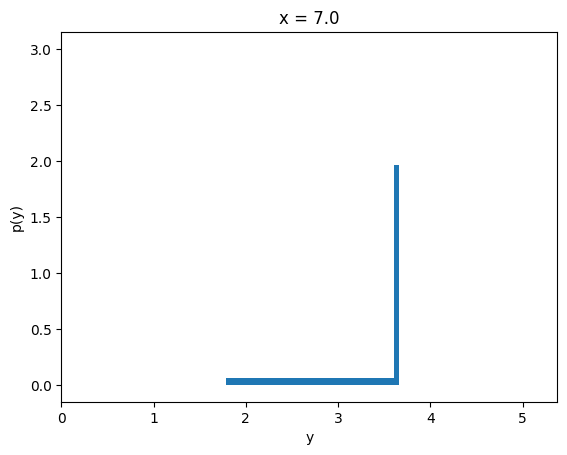

In [ ]:
densities = get_pdf(qs, q_vals)

fig = plt.figure()
plt.title(f"x = {xi}")
plt.fill_between(piecewise(q_vals), 0, doubled(densities))
# plt.fill_between(q_values, 0, densities + [0])
# plt.plot(q_values, densities + [0], color="k")
plt.xlim(0, y.max())
plt.gca().set_xlabel("y")
plt.gca().set_ylabel("p(y)")

In [ ]:
q_vals

array([1.7879791, 3.604815 , 3.6601908, 3.6609426, 3.6609511, 3.6609526,
       3.6609547, 3.6609638, 3.6610367, 3.6621094], dtype=float32)

In [ ]:
from empiricaldist import Pmf, Cdf

pmf = Pmf(densities)
pmf.normalize()

153310.90899288206

<Axes: >

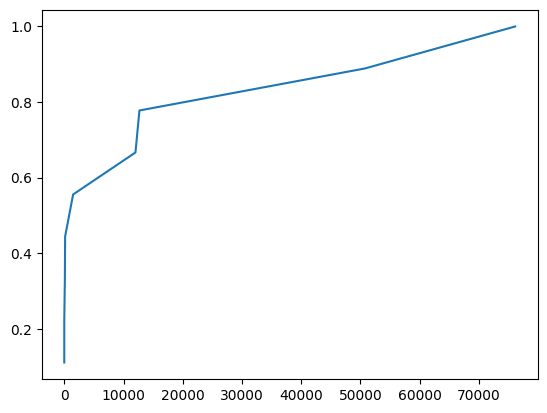

In [ ]:
cdf = Cdf.from_seq(densities)
cdf.plot()